In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# **Colab uses GPU**

In [4]:
#' ' means CPU whereas '/device:G:0' means GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# **Import Necessary Libraries**

In [115]:
import os
import time
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib
import matplotlib.pyplot as plt

from keras_preprocessing.image import ImageDataGenerator,load_img
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization 
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.optimizers import RMSprop
from keras.applications import VGG19, ResNet50, InceptionV3,VGG16

print(tf.__version__)


1.15.0


# **Unzip the Dataset**

In [0]:
zip_ref = zipfile.ZipFile('drive/My Drive/Datasets/Flowers.zip', 'r')
zip_ref.extractall('Flower') # unzip directory
zip_ref.close()

# **Load Data and Create Data Frame**

In [7]:
flower_class = pd.read_csv('Flower/classlabels.txt', header = None, names=['Images','Class'])
flower_class

,Images,Class
0,JFT_00001.jpg,1
1,JFT_00002.jpg,1
2,JFT_00003.jpg,1
3,JFT_00004.jpg,1
4,JFT_00006.jpg,1
...,...,...
1474,JFT_01467.jpg,29
1475,JFT_01470.jpg,30
1476,JFT_01472.jpg,30
1477,JFT_01476.jpg,30


In [8]:
flower_class['N_Images']= flower_class['Images'].str.strip('JFT_0000').str.strip('.jpg')
flower_class

,Images,Class,N_Images
0,JFT_00001.jpg,1,1
1,JFT_00002.jpg,1,2
2,JFT_00003.jpg,1,3
3,JFT_00004.jpg,1,4
4,JFT_00006.jpg,1,6
...,...,...,...
1474,JFT_01467.jpg,29,1467
1475,JFT_01470.jpg,30,1470
1476,JFT_01472.jpg,30,1472
1477,JFT_01476.jpg,30,1476


# **Calculate the Baseline**

In [9]:
base_line = 100*flower_class['Class'].value_counts()/len(flower_class)
base_line

6     4.732928
28    4.597701
23    4.530088
13    4.462475
4     4.462475
2     4.394861
7     4.327248
18    4.259635
29    4.259635
20    4.124408
27    4.124408
24    4.056795
10    4.056795
25    3.786342
19    3.718729
14    3.651116
5     3.651116
22    3.313049
12    3.245436
9     3.110210
17    3.042596
3     2.772143
21    2.569304
11    2.434077
26    2.366464
8     1.893171
16    1.622718
15    0.878972
30    0.811359
1     0.743746
Name: Class, dtype: float64

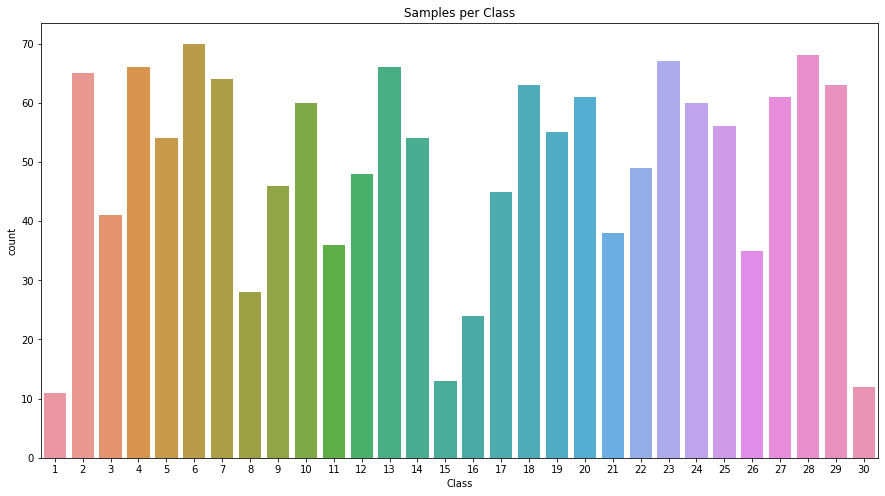

In [10]:
plt.figure(figsize=(15, 8))
sns.countplot(x='Class',data=flower_class)
plt.title("Samples per Class")
plt.show()

In [11]:
train1 = pd.read_csv('Flower/tst1.txt',header= None,names=['N_Images'])
train1['N_Images'] = train1['N_Images'].apply(str)
train1df = flower_class.merge(train1, on= 'N_Images')
train1df['Class'] = train1df['Class'].apply(str)
train1df

,Images,Class,N_Images
0,JFT_00005.jpg,1,5
1,JFT_00007.jpg,1,7
2,JFT_00011.jpg,1,11
3,JFT_00012.jpg,2,12
4,JFT_00013.jpg,2,13
...,...,...,...
916,JFT_01467.jpg,29,1467
917,JFT_01470.jpg,30,1470
918,JFT_01472.jpg,30,1472
919,JFT_01476.jpg,30,1476


In [12]:
val1 = pd.read_csv('Flower/val1.txt',sep = ' ',header= None,names=['N_Images'])
val1['N_Images'] = val1['N_Images'].apply(str)
val1df = flower_class.merge(val1, on= 'N_Images')
val1df['Class'] = val1df['Class'].apply(str)
val1df

,Images,Class,N_Images
0,JFT_00001.jpg,1,1
1,JFT_00003.jpg,1,3
2,JFT_00006.jpg,1,6
3,JFT_00008.jpg,1,8
4,JFT_00018.jpg,2,18
...,...,...,...
274,JFT_01462.jpg,29,1462
275,JFT_01469.jpg,30,1469
276,JFT_01471.jpg,30,1471
277,JFT_01474.jpg,30,1474


In [13]:
test1 = pd.read_csv('Flower/trn1.txt',sep = ' ',header= None,names=['N_Images'])
test1['N_Images'] = test1['N_Images'].apply(str)
test1df = flower_class.merge(test1, on= 'N_Images')
test1df['Class'] = test1df['Class'].apply(str)
test1df

,Images,Class,N_Images
0,JFT_00002.jpg,1,2
1,JFT_00004.jpg,1,4
2,JFT_00009.jpg,1,9
3,JFT_00010.jpg,1,10
4,JFT_00021.jpg,2,21
...,...,...,...
274,JFT_01466.jpg,29,1466
275,JFT_01468.jpg,30,1468
276,JFT_01473.jpg,30,1473
277,JFT_01475.jpg,30,1475


In [14]:
print("Total Number of Images",flower_class.shape[0])
print("Number of Training Images", train1df.shape[0])
print("Number of Validation Images", val1df.shape[0])
print("Number of Training Images", test1df.shape[0])

Total Number of Images 1479
Number of Training Images 921
Number of Validation Images 279
Number of Training Images 279


# **Data Augmentation**

In [16]:
datagen=ImageDataGenerator(rescale=1./255.,
                           featurewise_center=False,
                           featurewise_std_normalization=False,
                           rotation_range=90,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           horizontal_flip=True,
                           vertical_flip=True)

train1_generator=datagen.flow_from_dataframe(
dataframe=train1df,
directory="Flower/jpg/",
x_col="Images",
y_col="Class",
subset="training",
batch_size=128,
seed=42,
shuffle=True,
class_mode="categorical",
color_mode="rgb",
#target_size=(256,256))
target_size=(128,128))
print('Train generator created')


val1_generator=datagen.flow_from_dataframe(
dataframe=val1df,
directory="Flower/jpg/",
x_col="Images",
y_col="Class",
subset="training",
batch_size=128,
seed=42,
shuffle=True,
class_mode="categorical",
#target_size=(256,256))
target_size=(128,128))
print('Validation generator created')

test1_generator=datagen.flow_from_dataframe(
dataframe=test1df,
directory="Flower/jpg/",
x_col="Images",
y_col="Class",
subset="training",
#batch_size=128,
batch_size= 1,
color_mode="rgb",
seed=42,
shuffle=False,
#class_mode="sparse",
class_mode = None,
#target_size=(256,256))
target_size=(128,128))
print('Test generator created')

Found 921 validated image filenames belonging to 30 classes.
Train generator created
Found 279 validated image filenames belonging to 30 classes.
Validation generator created
Found 279 validated image filenames.
Test generator created


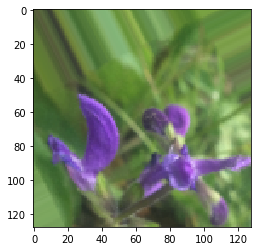

In [17]:
image, label = next(iter(train1_generator))
plt.imshow(image[0,:]);

# **Build the Model**

**VGG19** for fine tuning

In [0]:
model = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

In [75]:

for layer in vgg_conv.layers[:1]:
  layer.trainable = False

# Check the trainable status of the individual layers

for layer in vgg_conv.layers:
    print(layer, layer.trainable)


<keras.engine.input_layer.InputLayer object at 0x7eff363015f8> False
<keras.layers.convolutional.Conv2D object at 0x7eff35ca4cf8> False
<keras.layers.convolutional.Conv2D object at 0x7eff35cb5240> False
<keras.layers.pooling.MaxPooling2D object at 0x7eff35c63470> False
<keras.layers.convolutional.Conv2D object at 0x7eff35c93c18> False
<keras.layers.convolutional.Conv2D object at 0x7eff35c98470> False
<keras.layers.pooling.MaxPooling2D object at 0x7eff35c1b4e0> False
<keras.layers.convolutional.Conv2D object at 0x7eff35c20898> False
<keras.layers.convolutional.Conv2D object at 0x7eff35c289e8> False
<keras.layers.convolutional.Conv2D object at 0x7eff35c2ca58> False
<keras.layers.convolutional.Conv2D object at 0x7eff35c38240> False
<keras.layers.pooling.MaxPooling2D object at 0x7eff35c39ba8> False
<keras.layers.convolutional.Conv2D object at 0x7eff35c47a90> False
<keras.layers.convolutional.Conv2D object at 0x7eff35c50358> False
<keras.layers.convolutional.Conv2D object at 0x7eff35c56128>

In [116]:
from keras import models
from keras import layers
from keras import optimizers

# Create the model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(30, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_10 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_35 (Dense)             (None, 1024)              8389632   
_________________________________________________________________
dropout_16 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 30)                30750     
Total params: 28,444,766
Trainable params: 8,420,382
Non-trainable params: 20,024,384
_________________________________________________________________


# **Compile the model**

In [0]:
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) # optimizer=RMSprop(lr=0.001)
model.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4),metrics=['acc'])
#optimizers.RMSprop(lr=1e-4)

In [119]:
# Train the model
from keras.callbacks import EarlyStopping

early_stopping_monitor = EarlyStopping(patience=3)
EPOCHS = 500

history = model.fit_generator(
      train1_generator,validation_data = val1_generator, 
                   epochs=EPOCHS, callbacks=[early_stopping_monitor],
                   verbose=1)  


Epoch 1/500
8/8 [==============================] - 23s 3s/step - loss: 3.2350 - acc: 0.1336 - val_loss: 2.7999 - val_acc: 0.3118
Epoch 2/500
8/8 [==============================] - 21s 3s/step - loss: 2.5067 - acc: 0.3312 - val_loss: 2.2812 - val_acc: 0.4624
Epoch 3/500
8/8 [==============================] - 21s 3s/step - loss: 2.1028 - acc: 0.4439 - val_loss: 2.0867 - val_acc: 0.4910
Epoch 4/500
8/8 [==============================] - 21s 3s/step - loss: 1.9349 - acc: 0.4843 - val_loss: 1.8763 - val_acc: 0.5448
Epoch 5/500
8/8 [==============================] - 21s 3s/step - loss: 1.6411 - acc: 0.5729 - val_loss: 1.8456 - val_acc: 0.4695
Epoch 6/500
8/8 [==============================] - 21s 3s/step - loss: 1.5491 - acc: 0.5996 - val_loss: 1.5652 - val_acc: 0.6129
Epoch 7/500
8/8 [==============================] - 21s 3s/step - loss: 1.4495 - acc: 0.5882 - val_loss: 1.4810 - val_acc: 0.6201
Epoch 8/500
8/8 [==============================] - 21s 3s/step - loss: 1.2823 - acc: 0.6501 - val

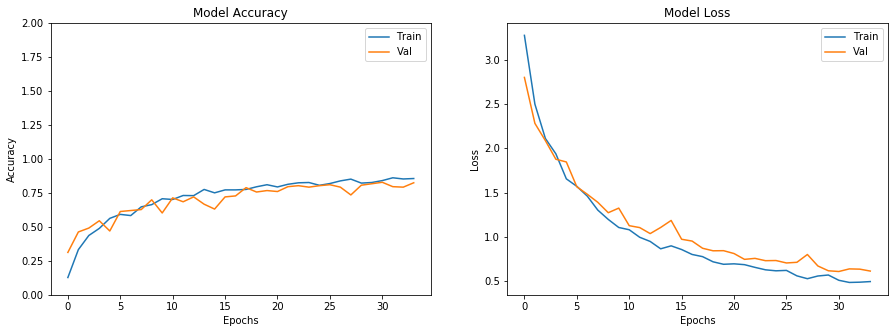

In [120]:
def plot_history(history):
  plt.figure(figsize=(15, 5))
  plt.subplot(1, 2, 1)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.plot(history.epoch, np.array(history.history['acc']),
           label='Train')
  plt.plot(history.epoch, np.array(history.history['val_acc']),
           label = 'Val')
  plt.title('Model Accuracy')
  plt.legend()
  plt.ylim([0, 2])

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'],label='Train')
  plt.plot(history.history['val_loss'],label='Val')
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend()
  plt.show()

plot_history(history)

# **Model evaluation**

**Test set**

In [121]:
val1_generator.reset()
pred=model.predict_generator(val1_generator,
verbose=1)

3/3 [==============================] - 6s 2s/step


In [0]:
predicted_class_indices=np.argmax(pred,axis=1)

In [0]:
labels = (train1_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [124]:
filenames=val1_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.head(10)
results.to_csv("results.csv",index=False)

,Filename,Predictions
0,JFT_00001.jpg,28
1,JFT_00003.jpg,23
2,JFT_00006.jpg,2
3,JFT_00008.jpg,11
4,JFT_00018.jpg,22
5,JFT_00020.jpg,21
6,JFT_00024.jpg,27
7,JFT_00026.jpg,27
8,JFT_00050.jpg,2
9,JFT_00051.jpg,30
